In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
loan = pd.read_csv('masked_kiva_loans.csv')
loan_time_series =loan[['funded_amount', 'date']].copy()
loan_time_series['date'] =pd.to_datetime(loan_time_series['date'])
loan_time_series.head()

,funded_amount,date
0,500,2017-02-20
1,325,2016-10-11
2,800,2016-07-25
3,425,2017-06-02
4,275,2015-03-25


In [3]:
print("Num of duplicated records:")
print(sum(loan_time_series.duplicated()))
print("---------------------")

Num of duplicated records:
10611
---------------------


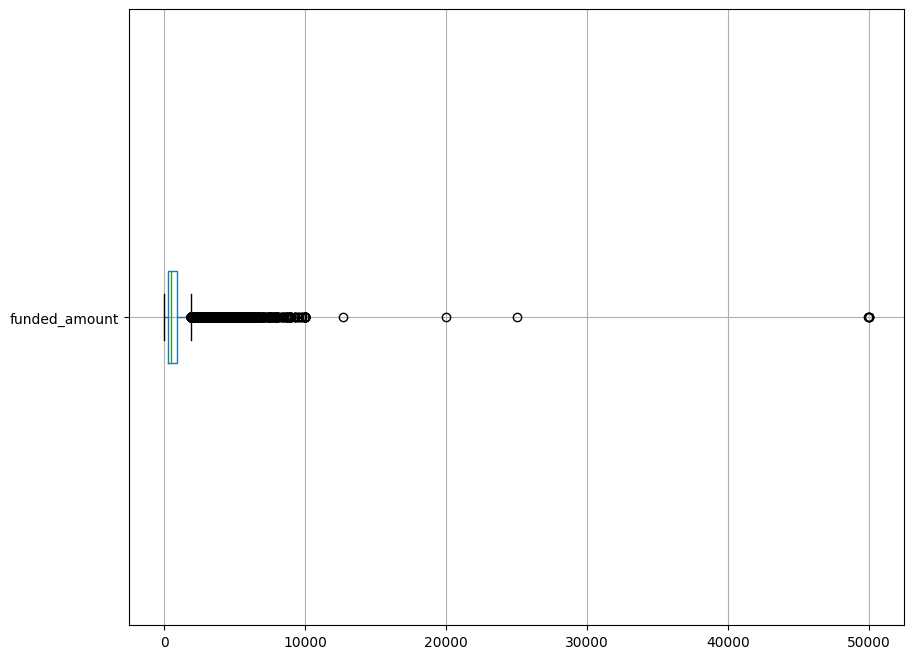

In [4]:
# Boxplots
plt.figure(figsize=(10, 8))
numerical_variables =['funded_amount', 'date']
loan_time_series[numerical_variables].boxplot(vert=False)
plt.show()

In [6]:
# Groupby date
Time_series_median = loan_time_series.groupby('date')['funded_amount'].sum().reset_index()

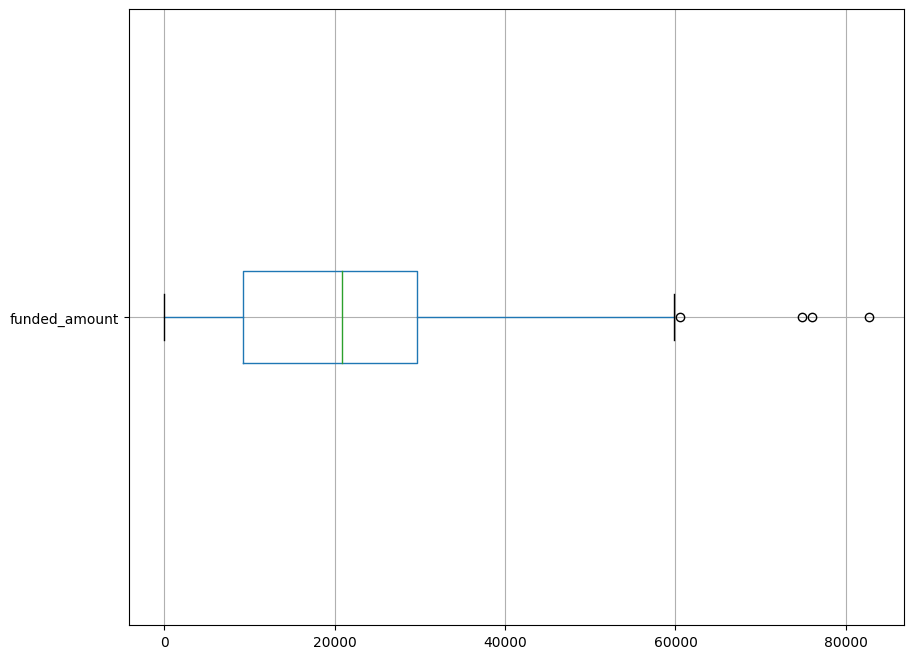

In [7]:
# Boxplots
plt.figure(figsize=(10, 8))
numerical_variables =['funded_amount', 'date']
Time_series_median[numerical_variables].boxplot(vert=False)
plt.show()

In [8]:
print("Num of duplicated records:")
print(sum(Time_series_median.duplicated()))
print("---------------------")

Num of duplicated records:
0
---------------------


In [10]:
Time_series_median.set_index('date', inplace=True)

In [11]:
Time_series_median.head()

,funded_amount
date,
2014-01-01,250
2014-01-02,26500
2014-01-03,21750
2014-01-04,3450
2014-01-05,2575


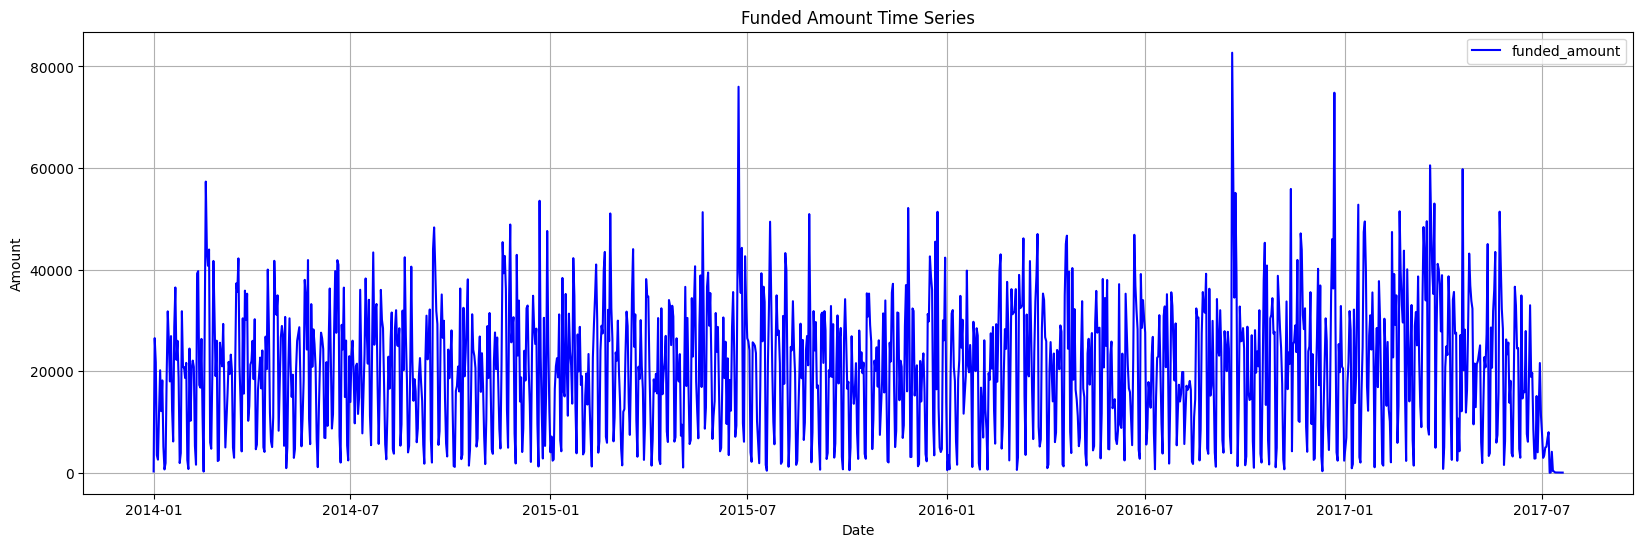

In [12]:
# Visualize the time series
plt.figure(figsize=(20, 6))
plt.plot(Time_series_median.index, Time_series_median['funded_amount'], label='funded_amount', color='blue')
plt.title('Funded Amount Time Series')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend(loc='best')
plt.grid(True)
plt.show()

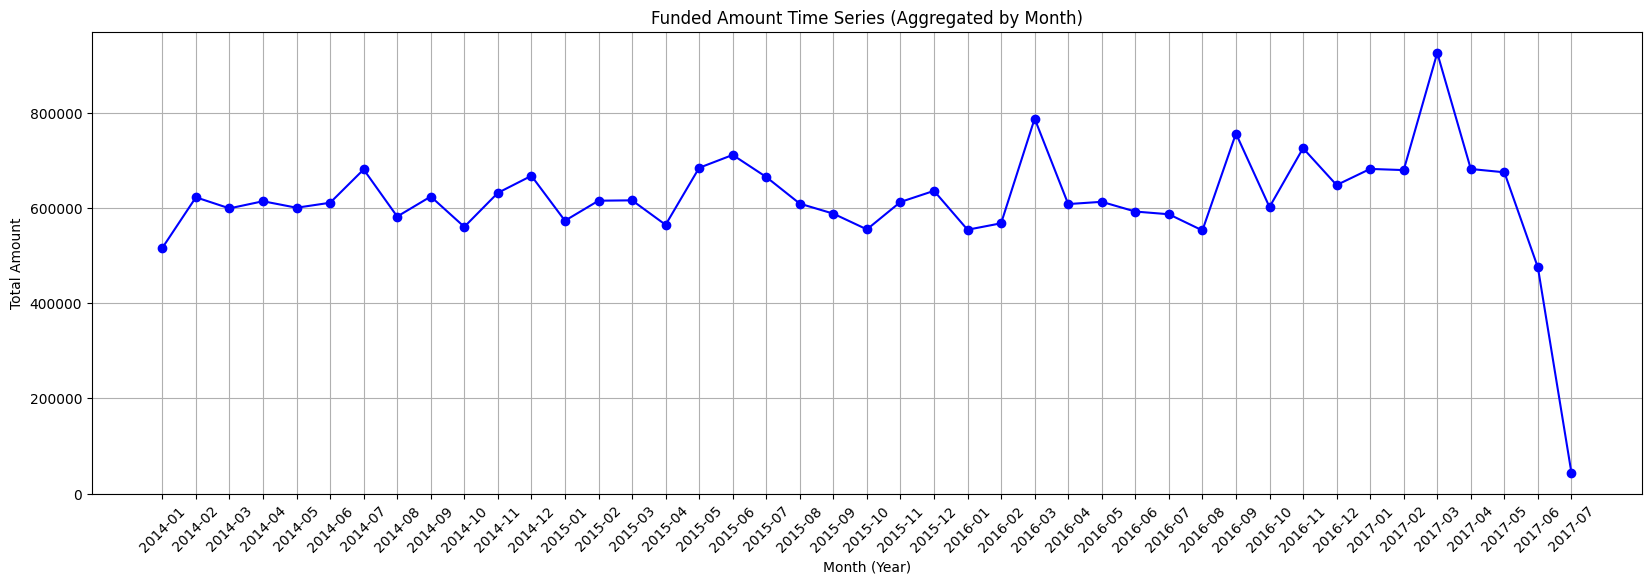

In [13]:
#Time series data by month for every year and sum the values for each month
Time_series_median_monthly = Time_series_median.resample('M').sum()
plt.figure(figsize=(20, 6))
plt.plot(Time_series_median_monthly.index.strftime('%Y-%m'), Time_series_median_monthly['funded_amount'], marker='o', linestyle='-', color='blue')
plt.title('Funded Amount Time Series (Aggregated by Month)')
plt.xlabel('Month (Year)')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


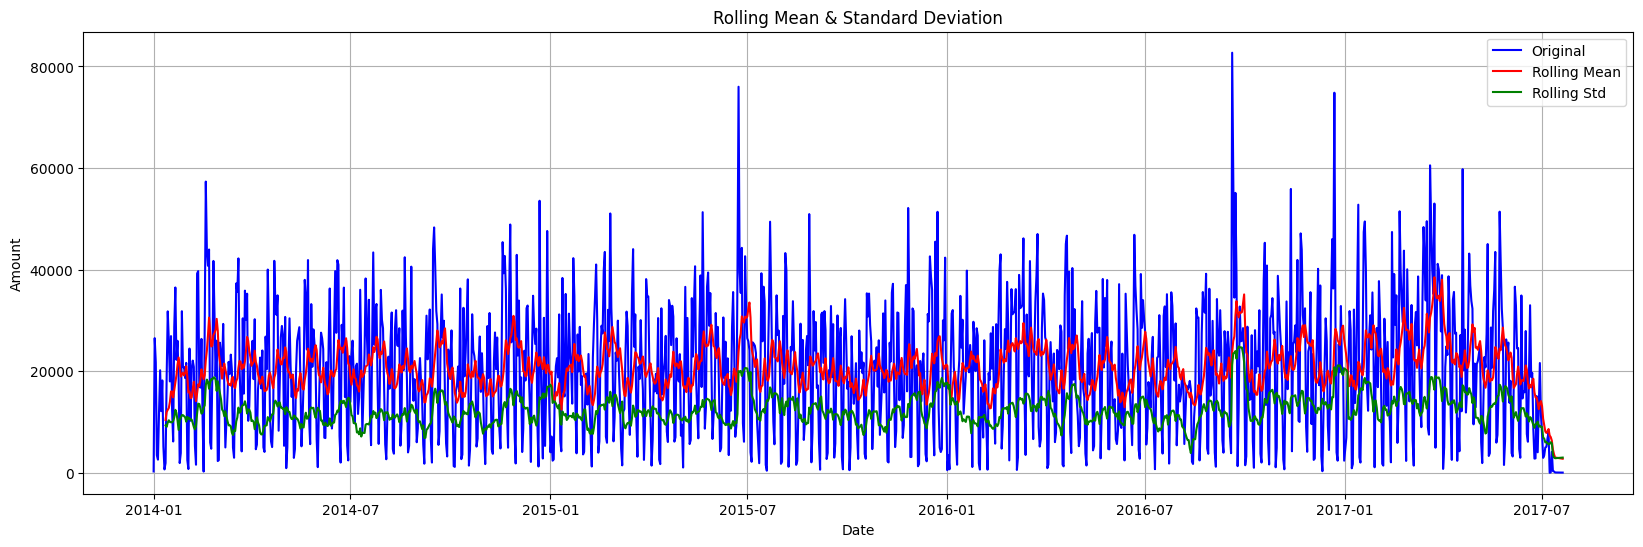

ADF Statistic: -6.200741674126448
p-value: 5.815667967883438e-08
Critical Values:
	1%: -3.4355381554821585
	5%: -2.8638311143598556
	10%: -2.567989813198476


In [14]:
#Stationarize the series
def stationarize_series(series):
    rolling_mean = series.rolling(window=12).mean()
    rolling_std = series.rolling(window=12).std()

    plt.figure(figsize=(20, 6))
    plt.plot(series, label='Original', color='blue')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    #Dickey-Fuller test
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
stationarize_series(Time_series_median['funded_amount'])


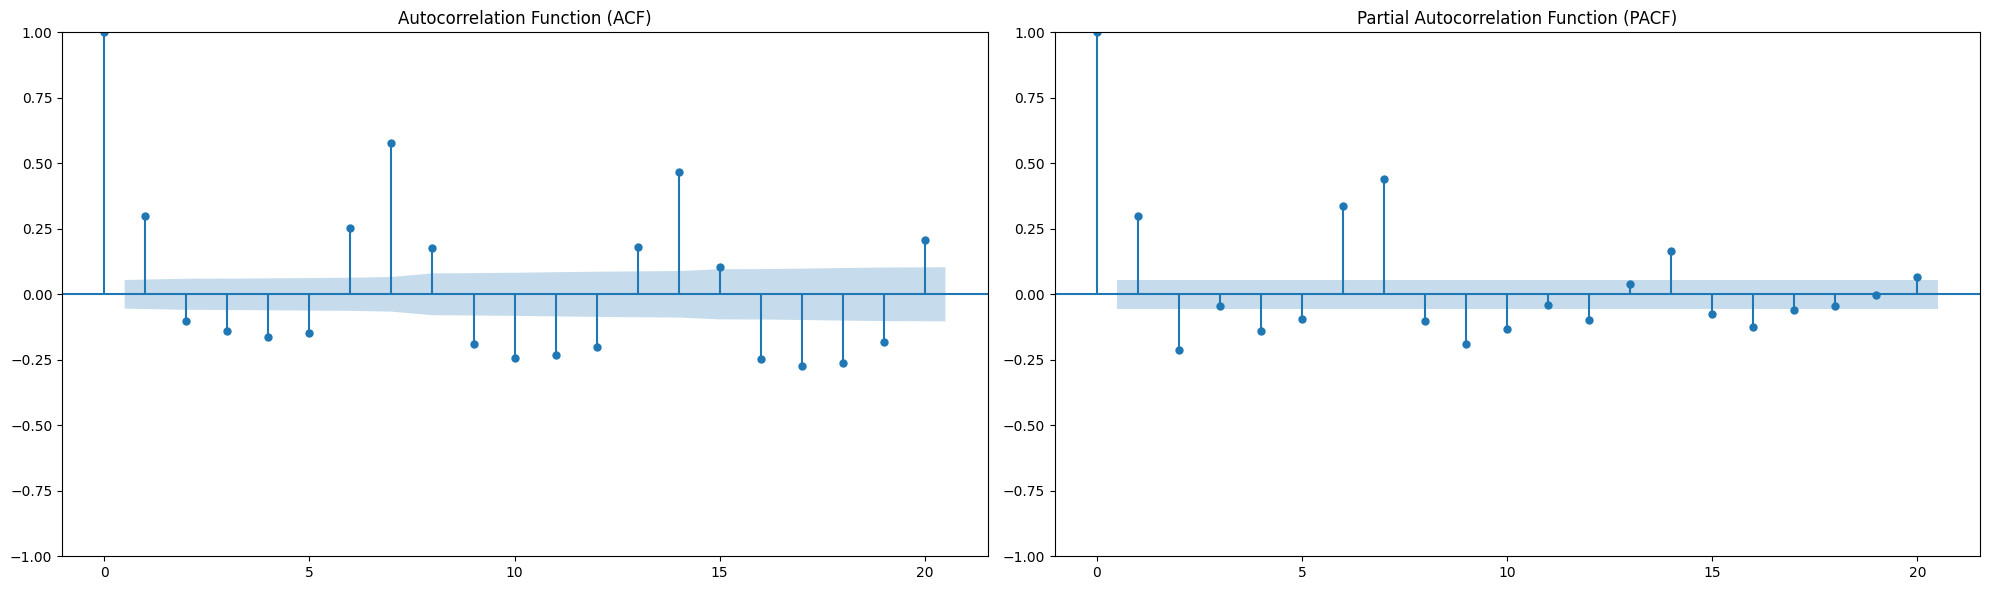

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
plot_acf(Time_series_median.funded_amount.dropna(), ax=ax1, lags=20, title='Autocorrelation Function (ACF)')
plot_pacf(Time_series_median.funded_amount.dropna(), ax=ax2, lags=20, title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


#Split Data

In [ ]:
train_size = int(len(Time_series_median) * 0.8)
train, test = Time_series_median[:train_size], Time_series_median[train_size:]

In [ ]:
model = ARIMA(train['funded_amount'], order=(15,0,15))
arima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
start = len(train)
end = len(train) + len(test) - 1
pred = arima_model.predict(start=start, end=end,typ = 'levels')
pred.index= Time_series_median.index[start:end+1]

print(pred)

date
2016-10-30     7239.486488
2016-10-31    23514.111600
2016-11-01    26734.589296
2016-11-02    25484.346403
2016-11-03    20707.161738
                  ...     
2017-07-10    19543.606247
2017-07-11    24600.969398
2017-07-12    23769.295859
2017-07-13    19074.542851
2017-07-20    13110.922370
Name: predicted_mean, Length: 257, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='date'>

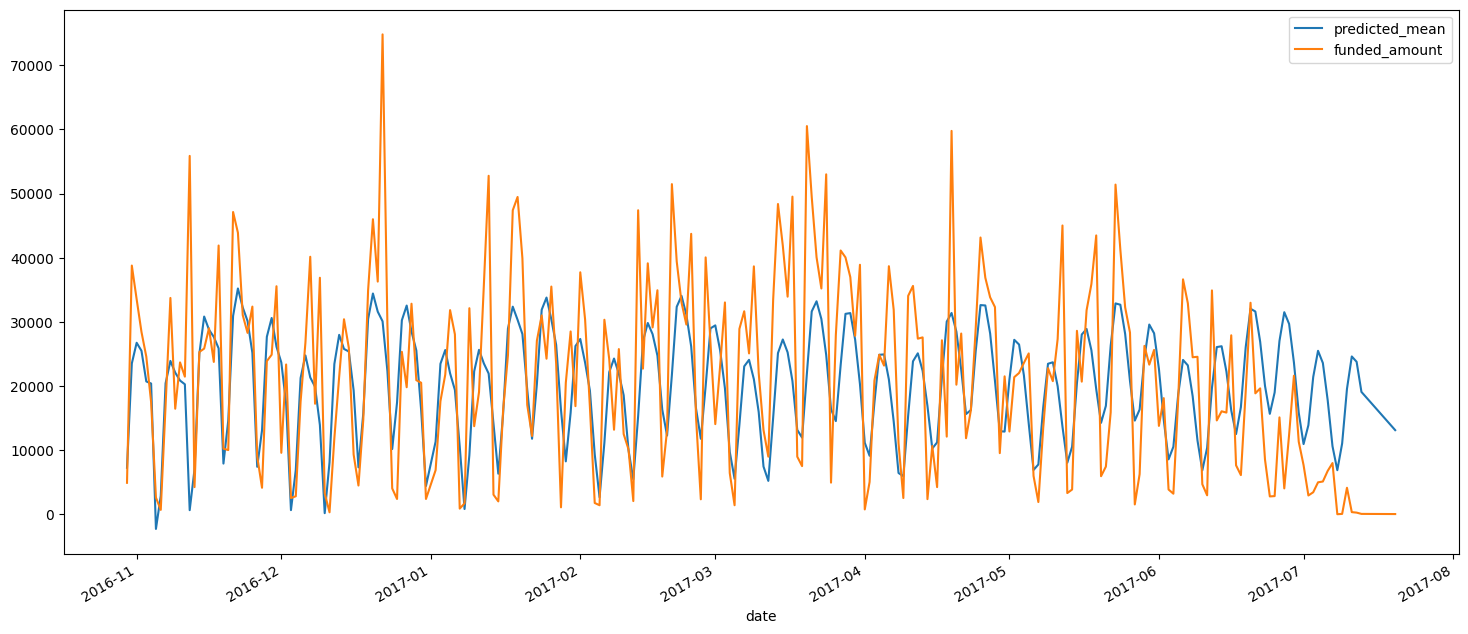

In [ ]:
pred.plot(figsize=(18,8),legend = True)
test['funded_amount'].plot(legend = True )

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(test['funded_amount'], pred)
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.34201837266891433


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


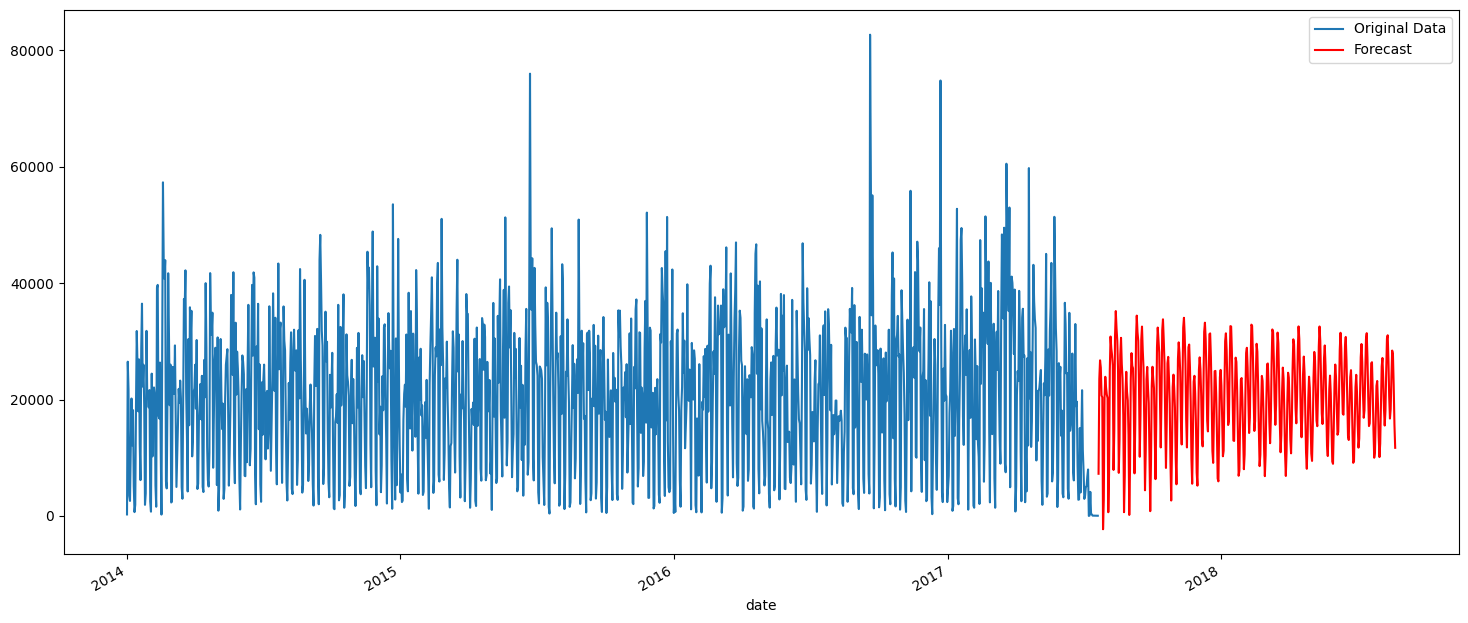

In [ ]:
start_date = '2017-07-21'
end_date = '2018-08-21'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

forecast = arima_model.forecast(steps=len(pd.date_range(start=start_date, end=end_date, freq=Time_series_median.index.freq)))
forecast_index = pd.date_range(start=start_date, end=end_date, freq=Time_series_median.index.freq)

plt.figure(figsize=(18, 8))
Time_series_median['funded_amount'].plot(label='Original Data') #plot original
plt.plot(forecast_index, forecast, label='Forecast', color='red') #plot forecast
plt.legend()
plt.show()